In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException


In [2]:
"""
# Créer un exmple de dictionnaire
dictionary = {
    'name1': ('5 stars', '7 years ago', "It is so bad"),
    'name2': ('5 stars', '7 years ago', 'it sucks'),
    'name3': ('5 stars', '7 years ago', "It's okay"),
    'name4': ('5 stars', '7 years ago', 'It is very good'),
    'name5': ('5 stars', '7 years ago', "c'est un peu nul"),
    'name6': ('5 stars', '7 years ago', "Le robot est très bon"),
    'name7': ('5 stars', '7 years ago', "The robot is very good"),
    'name8': ('5 stars', '7 years ago', "El robot es muy bueno"),
    'name9': ('5 stars', '7 years ago', "Il robot è molto buono"),
}
df = pd.DataFrame(dictionary, index=['grading', 'date', 'Text']).T
"""

'\n# Créer un exmple de dictionnaire\ndictionary = {\n    \'name1\': (\'5 stars\', \'7 years ago\', "It is so bad"),\n    \'name2\': (\'5 stars\', \'7 years ago\', \'it sucks\'),\n    \'name3\': (\'5 stars\', \'7 years ago\', "It\'s okay"),\n    \'name4\': (\'5 stars\', \'7 years ago\', \'It is very good\'),\n    \'name5\': (\'5 stars\', \'7 years ago\', "c\'est un peu nul"),\n    \'name6\': (\'5 stars\', \'7 years ago\', "Le robot est très bon"),\n    \'name7\': (\'5 stars\', \'7 years ago\', "The robot is very good"),\n    \'name8\': (\'5 stars\', \'7 years ago\', "El robot es muy bueno"),\n    \'name9\': (\'5 stars\', \'7 years ago\', "Il robot è molto buono"),\n}\ndf = pd.DataFrame(dictionary, index=[\'grading\', \'date\', \'Text\']).T\n'

In [3]:
# Convertir le dictionnaire en DataFrame

df = pd.read_csv('data.csv', sep=',')
df = df.dropna()

# Remplacer les valeurs dans grading par des int
df["grading"] = [int(x[0]) if x[0].isdigit() and "/" not in x else int(5*float(x.split('/')[0])/float(x.split('/')[1])) for x in df["grading"]]

# Remplace date par un dictionnaire {months: number, years: number}
def transform_date(date):
    weeks_or_days = ['week', 'day', 'semaine', 'jour']
    date_array = date.split()
    if any(word in date_array for word in weeks_or_days):
        return {'months': 0, 'years': 0}
    elif 'month' in date or 'mois' in date:
        if date_array[0].isdigit():
            return {'months': int(date_array[0]), 'years': 0}
        return {'months': 1, 'years': 0}
    elif date_array[0].isdigit():
        return {'months': int(date_array[0])*12, 'years': int(date_array[0])}
    return {'months': 12, 'years': 1}

df["date"] = df["date"].apply(transform_date)

df.index_name = 'ID'
# Renommer la colonne d'index en "ID"
df = df.rename_axis('ID').reset_index()
df.set_index('ID', inplace=True)
# Ajouter la colonne Language à la DataFrame

# Pour que les détections soient consistent
DetectorFactory.seed = 0
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

df['Language'] = df['Text'].apply(detect_language)
df.drop(df.loc[df['Language'] == 'unknown'].index, inplace=True)

df

                   Name  grading                        date  \
ID                                                             
0      Reezaane Bundhoo        4  {'months': 12, 'years': 1}   
1      Akram Althawbani        5   {'months': 3, 'years': 0}   
2          Ibrahim Sobh        4   {'months': 1, 'years': 0}   
3         Mareike Engel        5   {'months': 5, 'years': 0}   
4     shrishail kurangi        3   {'months': 6, 'years': 0}   
...                 ...      ...                         ...   
5009  Ammellle Ammellle        5  {'months': 48, 'years': 4}   
5010     Amélie Glorian        4  {'months': 12, 'years': 1}   
5012          jules qci        5  {'months': 72, 'years': 6}   
5013        Pierre Yger        5  {'months': 48, 'years': 4}   
5014  Valentin Delepaut        5  {'months': 36, 'years': 3}   

                                                   Text Language  
ID                                                                
0     Delicious cakes, hot/cold b

## Translation

In [4]:
"""#pip install google-cloud-translate==2.0.1
from google.cloud import translate_v2 as translate
import os, json
from dotenv import load_dotenv
load_dotenv()

CREDENTIALS = json.loads(os.environ.get('CREDENTIALS'))

if os.path.exists('credentials.json'):
    pass
else:
    with open('credentials.json', 'w') as credFile:
        json.dump(CREDENTIALS, credFile)
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'credentials.json'

def translate_text(row):
    translate_client = translate.Client()

    text = row['Text']
    if isinstance(text, bytes):
        text = text.decode("utf-8")

    # Only translate the text if the language isn't 'en'.
    if row['Language'] != 'en':
        try:
            result = translate_client.translate(text, target_language='en')
            return pd.Series([result["translatedText"], 'en'])
        except Exception:
            return pd.Series([text, row['Language']])  # if translation fails, return original text and language
    else:
        return pd.Series([text, row['Language']])  # if text is already in English, return original text and language

df[['Text', 'Language']] = df.apply(translate_text, axis=1)
df
"""

from deep_translator import GoogleTranslator

def translate_text(row):
    text = row['Text']

    # translate the text to English
    if row['Language'] != 'en':
        translated_text = GoogleTranslator(source='auto', target='en').translate(text)
        return pd.Series([translated_text, 'en'])
    return row

# Apply the function to the DataFrame
df[['Text', 'Language']] = df.apply(translate_text, axis=1)
df


,Name,grading,date,Text,Language
ID,,,,,
0,Reezaane Bundhoo,4,"{'months': 12, 'years': 1}","Delicious cakes, hot/cold beverages and great ...",en
1,Akram Althawbani,5,"{'months': 3, 'years': 0}",Best place but it's still camels man opinion. ...,en
2,Ibrahim Sobh,4,"{'months': 1, 'years': 0}","Amazing place to buy bread and sweets , always...",en
3,Mareike Engel,5,"{'months': 5, 'years': 0}",Love the baguette and croissant. Staff is alwa...,en
4,shrishail kurangi,3,"{'months': 6, 'years': 0}",All the items I have tried here are really gre...,en
...,...,...,...,...,...
5009,Ammellle Ammellle,5,"{'months': 48, 'years': 4}",Very pleasant intimate room,en
5010,Amélie Glorian,4,"{'months': 12, 'years': 1}",old cinema,en
5012,jules qci,5,"{'months': 72, 'years': 6}",Good room nothing to say,en


## EDA

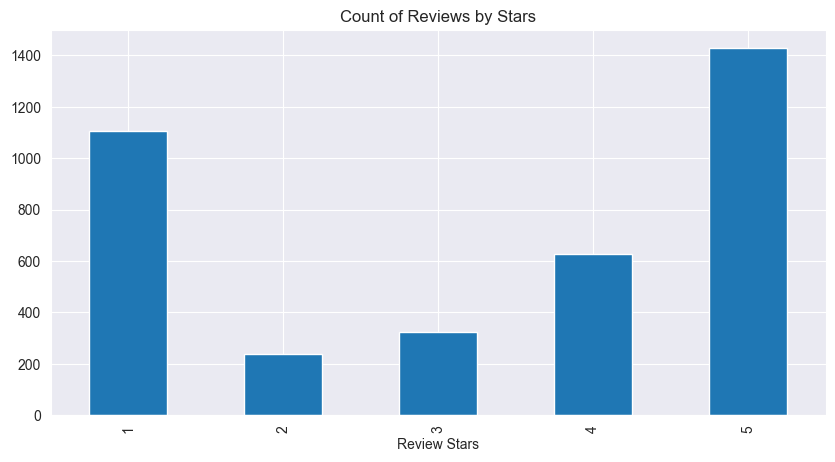

In [5]:
ax = df['grading'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Sentiment Analysis

### Roberta

In [6]:
from transformers import pipeline

C:\Users\jacqu\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from transformers import AutoTokenizer

# Sentiment Analysis with Roberta
"""
nlp = pipeline("sentiment-analysis", model=f"cardiffnlp/twitter-roberta-base-sentiment")

# Run the polarity score on the entire dataset
res = pd.DataFrame(columns=['label', 'score'])
for index, row in df.iterrows():
    text = row['Text']
    langue = row['Language']
    if langue == 'en':
        dict = pd.DataFrame(nlp(text))
        dict['ID'] = index
        res = pd.concat([res, dict], axis=0)
"""
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

nlp = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment", tokenizer=tokenizer)

res = pd.DataFrame(columns=['label', 'score'])
for index, row in df.iterrows():
    text = row['Text']
    langue = row['Language']

    # If the language is English and the token length doesn't exceed the limit
    if langue == 'en':
        tokens = tokenizer.encode(text, return_tensors='pt')

        if len(tokens[0]) <= 512:
            dict = pd.DataFrame(nlp(text))
            dict['ID'] = index
            res = pd.concat([res, dict], axis=0)

# Remplacement des valeurs
res['label'] = res['label'].replace('LABEL_0', 'NEGATIVE')
res['label'] = res['label'].replace('LABEL_1', 'NEUTRAL')
res['label'] = res['label'].replace('LABEL_2', 'POSITIVE')
res["ID"] = res['ID'].astype(int)
res = res.rename(columns={"label": "label (roberta)", "score": "score (roberta)"})
res.set_index('ID', inplace=True)

# Merge the two dataframes
df = df.merge(res, left_index=True, right_index=True, how='left')
df


WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.0.1+cu118 with CUDA 1108 (you have 2.0.1+cpu)
    Python  3.10.11 (you have 3.10.9)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


,Name,grading,date,Text,Language,label (roberta),score (roberta)
ID,,,,,,,
0,Reezaane Bundhoo,4,"{'months': 12, 'years': 1}","Delicious cakes, hot/cold beverages and great ...",en,POSITIVE,0.907862
1,Akram Althawbani,5,"{'months': 3, 'years': 0}",Best place but it's still camels man opinion. ...,en,POSITIVE,0.809464
2,Ibrahim Sobh,4,"{'months': 1, 'years': 0}","Amazing place to buy bread and sweets , always...",en,NEUTRAL,0.368061
3,Mareike Engel,5,"{'months': 5, 'years': 0}",Love the baguette and croissant. Staff is alwa...,en,POSITIVE,0.991683
4,shrishail kurangi,3,"{'months': 6, 'years': 0}",All the items I have tried here are really gre...,en,NEGATIVE,0.392930
...,...,...,...,...,...,...,...
5009,Ammellle Ammellle,5,"{'months': 48, 'years': 4}",Very pleasant intimate room,en,POSITIVE,0.966187
5010,Amélie Glorian,4,"{'months': 12, 'years': 1}",old cinema,en,NEUTRAL,0.736137
5012,jules qci,5,"{'months': 72, 'years': 6}",Good room nothing to say,en,POSITIVE,0.725447


## nlptown/bert-base-multilingual-uncased-sentiment

In [8]:
# Sentiment Analysis Bert-base-uncased
# Plusieurs langages disponibles (dont le français)
#English	150k
#Dutch	80k
#German	137k
#French	140k
#Italian	72k
#Spanish
# Il classifie les phrases en étoiles (1 à 5)
# Ce modèle est connu

nlp = pipeline("sentiment-analysis", model=f"nlptown/bert-base-multilingual-uncased-sentiment")

# Run the polarity score on the entire dataset
res = pd.DataFrame(columns=['label', 'score'])
for index, row in df.iterrows():
    text = row['Text']
    langue = row['Language']
    if langue == 'en' or langue == 'fr' or langue == 'es' or langue == 'it' or langue == 'de' or langue == 'nl':
        """
        dict = pd.DataFrame(nlp(text))
        dict['ID'] = index
        res = pd.concat([res, dict], axis=0)
        """
        tokens = tokenizer.encode(text, return_tensors='pt')

        if len(tokens[0]) <= 512:
            dict = pd.DataFrame(nlp(text))
            dict['ID'] = index
            res = pd.concat([res, dict], axis=0)

# Remplacement des valeurs
res['label'] = res['label'].replace('1 star', int(1))
res['label'] = res['label'].replace('2 stars', int(2))
res['label'] = res['label'].replace('3 stars', int(3))
res['label'] = res['label'].replace('4 stars', int(4))
res['label'] = res['label'].replace('5 stars', int(5))
res["ID"] = res['ID'].astype(int)
res = res.rename(columns={"label": "label (Bert), over 5", "score": "score (Bert)"})
res.set_index('ID', inplace=True)

# Merge the two dataframes
df = df.merge(res, left_index=True, right_index=True, how='left')
df

# print(df.isnull().sum())
# print(f"Negative: {df[df['label (roberta)'] == 'NEGATIVE'].count()}, Positive: {df[df['label (roberta)'] == 'POSITIVE'].count()}, Neutral: {df[df['label (roberta)'] == 'NEUTRAL'].count()}")

Token indices sequence length is longer than the specified maximum sequence length for this model (524 > 512). Running this sequence through the model will result in indexing errors


RuntimeError: The size of tensor a (524) must match the size of tensor b (512) at non-singleton dimension 1

## Using Sklearn

Accuracy: 0.8113207547169812
Precision: 0.8326112300552702
Recall: 0.8113207547169812
F1 Score: 0.7663429663232992


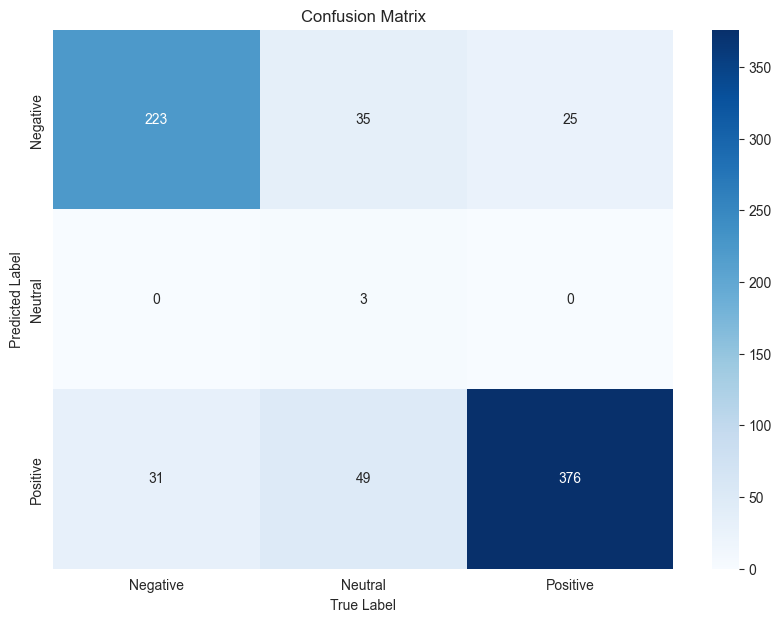

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df = df.drop(df[df['label (roberta)'].isna()].index)

# Assume X is your list of texts and y is your list of labels
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['label (roberta)'], test_size=0.2)

# Transform the text data into numerical vectors
vectorizer = CountVectorizer()
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

# Train the classifier
clf = MultinomialNB()
clf.fit(X_train_vectors, y_train)

# Test the classifier
predictions = clf.predict(X_test_vectors)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted', zero_division=0)
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# DISPLAY CONFUSION MATRIX
# Transpose the confusion matrix
cm = cm.T
# Define the labels of the matrix
labels = ['Negative', 'Neutral', 'Positive']
# Create a dataframe from the confusion matrix for easier plotting
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
# Display the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Predicted Label')
plt.xlabel('True Label')
plt.show()


## Comparaison des modèles